In [1]:
import numpy as np
import pandas as pd
import load_data as ld
import copy
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

In [2]:
class implicit_MF():
    
    def __init__(self, R, latent_size=50, ld=1e-3, epochs=200):
        
        self._R = R             # explicit matrix
        self._P = copy.deepcopy(self._R)    # implicit matrix
        self._P[self._P != 0] = 1
        self._N, self._M = R.shape
        self._latent = latent_size
        self._epochs =epochs
        self._alpha = 40
        self._C = 1 + self._alpha * self._R
        self._lambda = ld
        
        rstate = np.random.RandomState(0)
        #self._X = np.random.normal(0, 0.1, size=(self._N, latent_size))
        #self._Y = np.random.normal(0, 0.1, size=(self._M, latent_size))
        self._X = sparse.csr_matrix(rstate.normal(size=(self._N, latent_size))) # Random numbers in a m x rank shape
        self._Y = sparse.csr_matrix(rstate.normal(size=(self._M, latent_size))) # Normally this would be rank x n but we can 
        
    def update(self):

        lambda_eye = self._lambda * sparse.eye(self._latent) # Our regularization term lambda*I. 
        
        self._YTY = self._Y.T.dot(self._Y)
        for u in range(self._N):
            #C_u = np.diag(self._C[u, :])
            C_u = sparse.diags(self._C[u, :])
            YCu_IY = self._Y.T @ (C_u - np.identity(self._M)) @ self._Y
            YCuY = self._YTY + YCu_IY + lambda_eye #self._lambda * np.identity(self._latent)
            self._X[u, :] =  spsolve(YCuY, self._Y.T @ C_u @ self._P[u, :] )  #np.linalg.inv(YCuY) @ self._Y.T @ C_u @ self._P[u, :] 

        self._XTX = self._X.T.dot(self._X)
        for i in range(self._M):
            #C_i = np.diag(self._C[:, i])
            C_i = sparse.diags(self._C[:, i])
            XCu_IX = self._X.T @ (C_i - np.identity(self._N)) @ self._X
            XCuX = self._XTX + XCu_IX + lambda_eye #self._lambda * np.identity(self._latent)
            self._Y[i, :] = spsolve(XCuX, self._X.T @ C_i @ self._P[:, i] )  #np.linalg.inv(XCuX) @ self._X.T @ C_i @ self._P[:, i]
            
    def cost(self):
        loss = np.sum(np.multiply(self._C, np.square(self._P - self._X @ self._Y.T))) + self._lambda * (sparse.linalg.norm(self._X) + sparse.linalg.norm(self._Y))
        # (np.linalg.norm(self._X) + np.linalg.norm(self._Y))
        return loss

    def train(self):
        
        train_cost_list = []
        start_time = timer()
        for epoch in range(self._epochs):
            start = timer()
            
            self.update()
            train_cost = self.cost()
                
            train_cost_list.append(train_cost)
            
            print('traning iteration:{: d} ,train_cost:{: f}, time:{: f}'.format(epoch, train_cost, timer() - start))
                
        print("Total time for training : %.4f" % (timer()-start_time))
        return self._X, self._Y, train_cost_list   

In [3]:
df = ld.load_rating_data()
N, M = len(df.user_id.unique()), len(df.item_id.unique())
ratio = 0.8
print("N, M : ", N, M)
train, test = train_test_split(df, test_size=1-ratio)
val, test = train_test_split(test, test_size=0.5)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

N, M :  943 1682


In [4]:
R = np.zeros([N, M])    
for i in range(len(train)):
    R[int(train.iloc[i, 0])-1, int(train.iloc[i, 1])-1] = float(train.iloc[i, 2])

val_R = np.zeros([N, M])    
for i in range(len(val)):
    val_R[int(val.iloc[i, 0])-1, int(val.iloc[i, 1])-1] = float(val.iloc[i, 2])

In [6]:
occf1 = implicit_MF(R, latent_size=20, ld=0.002, epochs=10)
U1, V1, train_cost_list1 = occf1.train()

traning iteration: 0 ,train_cost: 1993132.769117, time: 180.515335
traning iteration: 1 ,train_cost: 431483.903921, time: 218.958199
traning iteration: 2 ,train_cost: 373191.889146, time: 201.829616
traning iteration: 3 ,train_cost: 354934.613776, time: 202.283791
traning iteration: 4 ,train_cost: 345737.127822, time: 199.429835
traning iteration: 5 ,train_cost: 340215.169925, time: 202.316178
traning iteration: 6 ,train_cost: 336595.296202, time: 190.645439
traning iteration: 7 ,train_cost: 334070.961879, time: 105.498459
traning iteration: 8 ,train_cost: 332229.099061, time: 114.445591
traning iteration: 9 ,train_cost: 330834.640141, time: 111.966656
Total time for training : 1727.8912


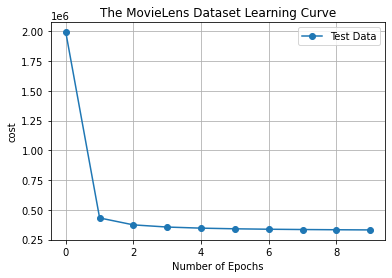

In [7]:
import matplotlib.pyplot as plt

# Check performance by plotting train and test errors
n = 10
m = 0
plt.plot(range(m, n), train_cost_list1[m:n], marker='o', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('cost')
plt.legend()
plt.grid()
plt.show()